In [3]:
import seaborn as sns
import pandas as pd
from pathlib import Path

In [83]:
results_path = Path("/Users/konsti/Library/CloudStorage/OneDrive-Personal/01_Education/Cambridge/PhD Docs/Own Publications/HEALNet/AAAI/results/healnet_aaai_results_v1.xlsx")

df_pivot = pd.read_excel(results_path, sheet_name="pivot", skiprows=4, header=[1,2])

In [96]:
df_raw = pd.read_excel(results_path, sheet_name="collection")

# replace "sources" strings
df_raw["sources"] = df_raw['sources'].str.replace(r'^\["omic"\s*,\s*"slides"\]$', 'omic_slides', regex=True)
df_raw["sources"] = df_raw['sources'].str.replace(r'^\["omic"\]$', 'omic', regex=True)
df_raw["sources"] = df_raw['sources'].str.replace(r'^\["slides"\]$', 'slides', regex=True)

# Capitalize models and datasets (only first letter)
df_raw["model"] = df_raw["model"].str.upper()
df_raw["dataset"] = df_raw["dataset"].str.upper()

# drop duplicate [model, dataset, sources] combinations
df_raw.drop_duplicates(subset=["model", "dataset", "sources"], inplace=True)


In [97]:
# df_temp = df_raw.groupby(["dataset"]).agg({"mean_test_c_index": "mean", "std_test_c_index": "mean"})

# get best baseline by group
df_baselines = df_raw[df_raw.sources != 'omic_slides'].groupby(["dataset", "model"], as_index=False).agg({"mean_test_c_index": "max"})
df_baselines.rename(columns={"mean_test_c_index": "best_baseline"}, inplace=True)
df = pd.merge(df_raw, df_baselines, on=["dataset", "model"], how="left")

# calculate uplift in % compared to best baseline
df["uplift"] = (df["mean_test_c_index"] - df["best_baseline"]) / df["best_baseline"] * 100
df = df[df.sources == "omic_slides"][["dataset", "model", "mean_test_c_index", "best_baseline", "uplift"]].dropna()

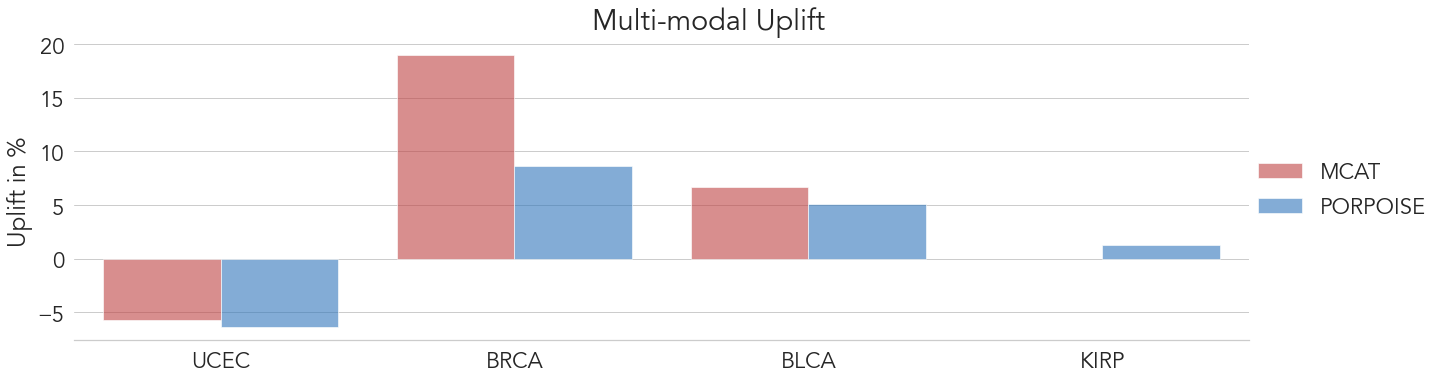

In [117]:
google_palette = [
    "#D32F2F", # blue 
    "#1976D2", # red
    "#388E3C", # yellow
    "#FBC02D", # green 
    "#8E24AA", # orange 
]

custom_palette = [
    "#7B2E7E",  # Main purple
    "#31A853",  # Bright green
    "#A45FA1",  # Lighter/Variation of purple
    "#FF7043",  # Muted orange/coral (contrasting to purple and green)
    "#1C4E80",  # Deep blue (complementary to orange and contrasting to purple)
    "#00ACC1"   # Cyan/Teal (additional contrasting color)
]


def plot_mm_uplift(df, title):
    sns.set_theme(style="whitegrid", font="Avenir", font_scale=2, palette=google_palette)    
    g = sns.catplot(
        data=df, kind="bar",
        x="dataset", y="uplift", hue="model", alpha=.6, height=6, 
        aspect=3 # increase for wider image
    )
    g.despine(left=True)
    g.set_axis_labels("", "Uplift in %")
    g.legend.set_title("")
    g.fig.suptitle(title)
    g.fig.subplots_adjust(top=0.9)
    # g.savefig(f"figures/{title}.png", dpi=300)
    
plot_mm_uplift(df, "Multi-modal Uplift")